### In this Notebook, the second part of Lab1 in the DataMining course is performed to improve maintainability and readability.

## Table of Contents
1. Data Source
2. Data Preparation 
3. Data Transformation
-  Converting Dictionary into Pandas dataframe
4. Data Mining using Pandas
 - 4.1 Dealing with Missing Values
 - 4.2 Dealing with Duplicate Data
5. Data Preprocessing
 - 5.1 Sampling
 - 5.2 Feature Creation
 - 5.3 Feature Subset Selection
 - 5.4 Dimensionality Reduction
 - 5.5 Atrribute Transformation / Aggregation
 - 5.6 Discretization and Binarization
6. Data Exploration
7. Conclusion


## 1. The Data
In this notebook we will explore Sentiment Labelled sentences, The used dataset could be found [here](https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences). The dataset contains sentences labelled with positive or negative sentiment. Additional information about the dataset, provided by the author of the website above, is provided below:

     This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015
     Please cite the paper if you want to use it :

     It contains sentences labelled with positive or negative sentiment.

     # Format:

     sentence 	 score 

     # Details:

     Score is either 1 (for positive) or 0 (for negative)	
     The sentences come from three different websites/fields:

     imdb.com
     amazon.com
     yelp.com

     For each website, there exist 500 positive and 500 negative sentences. Those were selected randomly for larger datasets  of reviews. 
     We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected. 

## 2 - 3. Data Preparation & Data Transformation
In this section we will extract the data from their files into one single panda dataframe.
The dataframe will ultimatly have the format:

INDEX   |   sentence    |    Score  |   Source    Positive/Negative   

Before presenting any code, I do the imports used in this notebook. Make sure to have the req. packages installed.

In [1]:
import os
import pandas as pd
import sys
sys.path.append('../')
import helpers.data_mining_helpers as dmh
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'
import math
from sklearn import preprocessing
from sklearn.preprocessing import binarize
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\albre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#Get the filepath to this directory
current_folder = os.getcwd()
#Add the filepath to the data
file_path = current_folder + "\sentiment+labelled+sentences\sentimentlabelledsentences\\" #Change file_path to fit where you put the txt files
#Create the categories for the sentiment
category = {0 : 'Negative', 1 : 'Positive'}

In [3]:
yelp_df = pd.read_csv(file_path + "yelp_labelled.txt", names=['sentence', 'Score'], sep='\t')
yelp_df['Source'] = 'Yelp'
print("Yelp DF shape: " + str(yelp_df.shape))

Yelp DF shape: (1000, 3)


In [4]:
amazon_df = pd.read_csv(os.path.join(file_path + "amazon_cells_labelled.txt"), names=['sentence', 'Score'], sep='\t')
amazon_df['Source'] = 'Amazon'
print("Amazon DF shape: " + str(amazon_df.shape))

Amazon DF shape: (1000, 3)


In [5]:

imdb_df = pd.read_csv(os.path.join(file_path + "imdb_labelled.txt"), names=['sentence', 'Score'], sep='\t')
imdb_df['Source'] = 'IMDB'
print("IMDB DF shape: " + str(imdb_df.shape))

IMDB DF shape: (748, 3)
New IMDB DF shape: (1000, 3)


Since it seems to be something wrong during the import of the IMDB records (only 748 records...) I will import the records using classic read from file operations and then sperate the string & lines

In [ ]:
file = open(file_path + "imdb_labelled.txt")
imdb_raw_data = file.read()
file.close
imdb_raw_data = imdb_raw_data.split('\n')

x = []
sentence = []
score = []
for line in imdb_raw_data[0:1000]: #Use index 0:1000 to avoid the last empty line. 
    x = line.split('\t')
    sentence.append(x[0])
    score.append(x[-1])
imdb_df = pd.DataFrame({'sentence' : sentence, 'Score' : score})
imdb_df['Source'] = 'IMDB'
print("New IMDB DF shape: " + str(imdb_df.shape))


In [6]:
#Concat all the data to one big df
df = pd.concat([amazon_df, yelp_df, imdb_df], axis=0)
df

sentence Score  Source
0    So there is no way for me to plug it in here i...     0  Amazon
1                          Good case, Excellent value.     1  Amazon
2                               Great for the jawbone.     1  Amazon
3    Tied to charger for conversations lasting more...     0  Amazon
4                                    The mic is great.     1  Amazon
..                                                 ...   ...     ...
995  I just got bored watching Jessice Lange take h...     0    IMDB
996  Unfortunately, any virtue in this film's produ...     0    IMDB
997                   In a word, it is embarrassing.       0    IMDB
998                               Exceptionally bad!       0    IMDB
999  All in all its an insult to one's intelligence...     0    IMDB

[3000 rows x 3 columns]

In [7]:
len(df)

3000

In [8]:
df[0:2]

sentence Score  Source
0  So there is no way for me to plug it in here i...     0  Amazon
1                        Good case, Excellent value.     1  Amazon

In [9]:
for sentence in df['sentence'][:3]:
    print(sentence)

So there is no way for me to plug it in here in the US unless I go by a converter.
Good case, Excellent value.
Great for the jawbone.


In [10]:
#Add Positive/Negative column to the DF
df['Positive/Negative'] = df.Score.apply(lambda t: dmh.format_labels_lab2(t, category))
df[0:10]

sentence Score  Source  \
0  So there is no way for me to plug it in here i...     0  Amazon   
1                        Good case, Excellent value.     1  Amazon   
2                             Great for the jawbone.     1  Amazon   
3  Tied to charger for conversations lasting more...     0  Amazon   
4                                  The mic is great.     1  Amazon   
5  I have to jiggle the plug to get it to line up...     0  Amazon   
6  If you have several dozen or several hundred c...     0  Amazon   
7        If you are Razr owner...you must have this!     1  Amazon   
8                Needless to say, I wasted my money.     0  Amazon   
9                   What a waste of money and time!.     0  Amazon   

  Positive/Negative  
0          Negative  
1          Positive  
2          Positive  
3          Negative  
4          Positive  
5          Negative  
6          Negative  
7          Positive  
8          Negative  
9          Negative

In [11]:
# a simple query
df[:10][["sentence","Positive/Negative"]]

sentence Positive/Negative
0  So there is no way for me to plug it in here i...          Negative
1                        Good case, Excellent value.          Positive
2                             Great for the jawbone.          Positive
3  Tied to charger for conversations lasting more...          Negative
4                                  The mic is great.          Positive
5  I have to jiggle the plug to get it to line up...          Negative
6  If you have several dozen or several hundred c...          Negative
7        If you are Razr owner...you must have this!          Positive
8                Needless to say, I wasted my money.          Negative
9                   What a waste of money and time!.          Negative

In [12]:
#Last 10
df[-10:]

sentence Score Source  \
990  The opening sequence of this gem is a classic,...     1   IMDB   
991             Fans of the genre will be in heaven.       1   IMDB   
992                Lange had become a great actress.       1   IMDB   
993                It looked like a wonderful story.       1   IMDB   
994            I never walked out of a movie faster.       0   IMDB   
995  I just got bored watching Jessice Lange take h...     0   IMDB   
996  Unfortunately, any virtue in this film's produ...     0   IMDB   
997                   In a word, it is embarrassing.       0   IMDB   
998                               Exceptionally bad!       0   IMDB   
999  All in all its an insult to one's intelligence...     0   IMDB   

    Positive/Negative  
990          Positive  
991          Positive  
992          Positive  
993          Positive  
994          Negative  
995          Negative  
996          Negative  
997          Negative  
998          Negative  
999          Negative

In [13]:
#using loc (by label)
df.loc[df.index[:10]]['sentence']

0    So there is no way for me to plug it in here i...
0                             Wow... Loved this place.
0    A very, very, very slow-moving, aimless movie ...
1                          Good case, Excellent value.
1                                   Crust is not good.
1    Not sure who was more lost - the flat characte...
2                               Great for the jawbone.
2            Not tasty and the texture was just nasty.
2    Attempting artiness with black & white and cle...
3    Tied to charger for conversations lasting more...
3    Stopped by during the late May bank holiday of...
3         Very little music or anything to speak of.  
4                                    The mic is great.
4    The selection on the menu was great and so wer...
4    The best scene in the movie was when Gerardo i...
5    I have to jiggle the plug to get it to line up...
5       Now I am getting angry and I want my damn pho.
5    The rest of the movie lacks art, charm, meanin...
6    If yo

The loc function result becomes weird since the indexes comes from the df first created, hence each index has three records, but for the sake of this task I consider it OK

In [14]:
# using iloc (by position)
df.iloc[:10, 0]

0    So there is no way for me to plug it in here i...
1                          Good case, Excellent value.
2                               Great for the jawbone.
3    Tied to charger for conversations lasting more...
4                                    The mic is great.
5    I have to jiggle the plug to get it to line up...
6    If you have several dozen or several hundred c...
7          If you are Razr owner...you must have this!
8                  Needless to say, I wasted my money.
9                     What a waste of money and time!.
Name: sentence, dtype: object

In [15]:
#The take home exercise 2, here i compare strings instead of the cat numbers.
df[(df['Source'] == 'IMDB') | (df['Source'] == 'Amazon')][::150]


sentence Score  Source  \
0    So there is no way for me to plug it in here i...     0  Amazon   
150                             I Was Hoping for More.     0  Amazon   
300                                   Sending it back.     0  Amazon   
450  i'm glad i found this product on amazon it is ...     1  Amazon   
600  Their Research and Development division obviou...     1  Amazon   
750  It is light, has plenty of battery capacity, a...     1  Amazon   
900  This was utterly confusing at first, which cau...     0  Amazon   
50   I'm glad the film didn't go for the most obvio...     1    IMDB   
200          This is definitely one of the bad ones.       0    IMDB   
350           Everything about this movie is stupid.       0    IMDB   
500  The entire audience applauded at the conclusio...     1    IMDB   
650  Nothing short of magnificent photography/cinem...     1    IMDB   
800  In fact, this stinker smells like a direct-to-...     0    IMDB   
950  Both Rickman and Stowe play their roles to the...     1    IMDB   

    Positive/Negative  
0            Negative  
150          Negative  
300          Negative  
450          Positive  
600          Positive  
750          Positive  
900          Negative  
50           Positive  
200          Negative  
350          Negative  
500          Positive  
650          Positive  
800          Negative  
950          Positive

In [16]:
#Exercise 3
df[df['Source'] == 'Yelp'].iloc[::10][0:5]

sentence Score Source  \
0                            Wow... Loved this place.     1   Yelp   
10                           Service was very prompt.     1   Yelp   
20                                The Burrittos Blah!     0   Yelp   
30  Also there are combos like a burger, fries, an...     1   Yelp   
40                       The shrimp tender and moist.     1   Yelp   

   Positive/Negative  
0           Positive  
10          Positive  
20          Negative  
30          Positive  
40          Positive

## 4. Data Mining using Pandas
In this section we will:
- See if there are any missing values.
- Check for duplicates.

In [17]:
# check missing values
df.isnull()

sentence  Score  Source  Positive/Negative
0       False  False   False              False
1       False  False   False              False
2       False  False   False              False
3       False  False   False              False
4       False  False   False              False
..        ...    ...     ...                ...
995     False  False   False              False
996     False  False   False              False
997     False  False   False              False
998     False  False   False              False
999     False  False   False              False

[3000 rows x 4 columns]

In [18]:
df.isnull().apply(lambda x: dmh.check_missing_values(x))

sentence                               Score  \
0  The amoung of missing records is:   The amoung of missing records is:    
1                                   0                                   0   

                               Source                   Positive/Negative  
0  The amoung of missing records is:   The amoung of missing records is:   
1                                   0                                   0

We can see that there is no missing values

In [19]:
#Check for each row instead
df.isnull().apply(lambda x: dmh.check_missing_values(x), axis=1)

0      (The amoung of missing records is: , 0)
1      (The amoung of missing records is: , 0)
2      (The amoung of missing records is: , 0)
3      (The amoung of missing records is: , 0)
4      (The amoung of missing records is: , 0)
                        ...                   
995    (The amoung of missing records is: , 0)
996    (The amoung of missing records is: , 0)
997    (The amoung of missing records is: , 0)
998    (The amoung of missing records is: , 0)
999    (The amoung of missing records is: , 0)
Length: 3000, dtype: object

Lets add dummies

In [20]:
dummy_series = pd.Series(["dummy_record", 1], index=["sentence", "Score"])
dummy_series
dummy_series.to_frame().T
# .to_frame() -> Convert Series to DataFrame
# .T          -> Transpose

sentence Score
0  dummy_record     1

In [21]:
result_with_series = pd.concat([df, dummy_series.to_frame().T], ignore_index=True)
# check if the records was commited into result
len(result_with_series)

3001

In [22]:
result_with_series.isnull().apply(lambda x: dmh.check_missing_values(x))

sentence                               Score  \
0  The amoung of missing records is:   The amoung of missing records is:    
1                                   0                                   0   

                               Source                   Positive/Negative  
0  The amoung of missing records is:   The amoung of missing records is:   
1                                   1                                   1

Lets add a dummy_dict to df

In [23]:
# dummy record as dictionary format
dummy_dict = [{'sentence': 'dummy_record',
               'Score': 1
              }]
df = pd.concat([df, pd.DataFrame(dummy_dict)], ignore_index=True)
print(len(df))
df.isnull().apply(lambda x: dmh.check_missing_values(x))

3001


sentence                               Score  \
0  The amoung of missing records is:   The amoung of missing records is:    
1                                   0                                   0   

                               Source                   Positive/Negative  
0  The amoung of missing records is:   The amoung of missing records is:   
1                                   1                                   1

In [24]:
#Time to drop the missing values
df.dropna(inplace=True)
print(len(df))
df.isnull().apply(lambda x: dmh.check_missing_values(x))

3000


sentence                               Score  \
0  The amoung of missing records is:   The amoung of missing records is:    
1                                   0                                   0   

                               Source                   Positive/Negative  
0  The amoung of missing records is:   The amoung of missing records is:   
1                                   0                                   0

EXERCISE 5 is omitted in this part since it was more of a general question.

# 4.2 Duplicate data
Lets continue with some duplicates

In [25]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2995    False
2996    False
2997    False
2998    False
2999    False
Length: 3000, dtype: bool

In [26]:
print(sum(df.duplicated()))
print(sum(df.duplicated('sentence')))

17
17


As we can see above there is 17 Duplicates... Let's investigate that further!

In [27]:
duplicates = df.duplicated(keep=False)
print(sum(df.duplicated( keep=False)))
print(df['sentence'][duplicates])
len(df)


34
18                                          Works great!.
179     If you like a loud buzzing to override all you...
180                               Don't buy this product.
187                                         Great phone!.
262                                          Works great.
285                                         Great phone!.
290                                          Great Phone.
392                                 This is a great deal.
402                      Excellent product for the price.
407                                          Works great.
446                                         Does not fit.
524                                         Works great!.
543                               Don't buy this product.
647                                          Great phone.
744     If you like a loud buzzing to override all you...
748                                         Does not fit.
778                                 This is a great deal.
792        

3000

After further investigation I would
say that it is likely that they are not
really duplicates since the sentences 
labeled as duplicates are pretty standard 
sentences for reviews, like "Great", 10/10 and so on
therefore I won't delete them. 

However for the sake of the task, I will 
create a copy of the df in this section 
and do the requested tasks.

The need for dummy duplicates is hence not needed

In [28]:
d_df = pd.DataFrame(df)
print(len(d_df))
print(sum(d_df.duplicated()))
#keep --> first to keep the first occourance of the record.
d_df.drop_duplicates(keep='first', inplace=True) # inplace applies changes directly on our dataframe
print(len(d_df))
print(len(df))



3000
17
2983
3000


## 5.  Data Preprocessing
The items we will cover in the preprocessing section of this notebook are as follows:

- Aggregation
- Sampling
- Dimensionality Reduction
- Feature Subset Selection
- Feature Creation
- Discretization and Binarization
- Attribute Transformation

### 5.1 Sampling
Let's start of with some sampling

In [29]:
print(df.shape)
df_sample = df.sample(n=1000,random_state=42) #random state
display(df_sample)
print(len(df_sample))
display(df_sample[0:4])

(3000, 4)


sentence Score  Source  \
1801                    And service was super friendly.     1    Yelp   
1190  you can watch them preparing the delicious food!)     1    Yelp   
1817    The seasonal fruit was fresh white peach puree.     1    Yelp   
251           O my gosh the best phone I have ever had.     1  Amazon   
2505  About ten minutes into this film I started hav...     0    IMDB   
...                                                 ...   ...     ...   
618   You need two hands to operate the screen.This ...     0  Amazon   
406   It's so stupid to have to keep buying new char...     0  Amazon   
1157  I ordered the Voodoo pasta and it was the firs...     1    Yelp   
1068  We got the food and apparently they have never...     0    Yelp   
1133                            The management is rude.     0    Yelp   

     Positive/Negative  
1801          Positive  
1190          Positive  
1817          Positive  
251           Positive  
2505          Negative  
...                ...  
618           Negative  
406           Negative  
1157          Positive  
1068          Negative  
1133          Negative  

[1000 rows x 4 columns]

1000


sentence Score  Source  \
1801                    And service was super friendly.     1    Yelp   
1190  you can watch them preparing the delicious food!)     1    Yelp   
1817    The seasonal fruit was fresh white peach puree.     1    Yelp   
251           O my gosh the best phone I have ever had.     1  Amazon   

     Positive/Negative  
1801          Positive  
1190          Positive  
1817          Positive  
251           Positive

EXERCISE 6 is omitted in this part since it was more of a general question.

Time for some visual representation

['Amazon', 'Yelp', 'IMDB']
Source
Amazon    1000
Yelp      1000
IMDB      1000
Name: count, dtype: int64


<Axes: title={'center': 'Source distribution'}, xlabel='Source'>

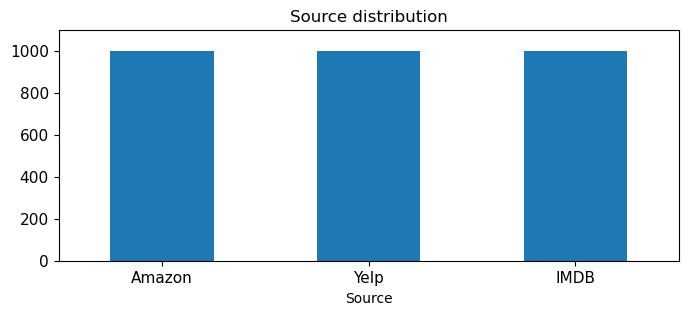

In [30]:
sources = ['Amazon', 'Yelp', 'IMDB']
print(sources)
print(df.Source.value_counts())

# plot barchart for df
df.Source.value_counts().plot(kind = 'bar',
                                    title = 'Source distribution',
                                    ylim = [0, 1100],        
                                    rot = 0, fontsize = 11, figsize = (8,3))


Source
Amazon    344
IMDB      330
Yelp      326
Name: count, dtype: int64


<Axes: title={'center': 'Source distribution'}, xlabel='Source'>

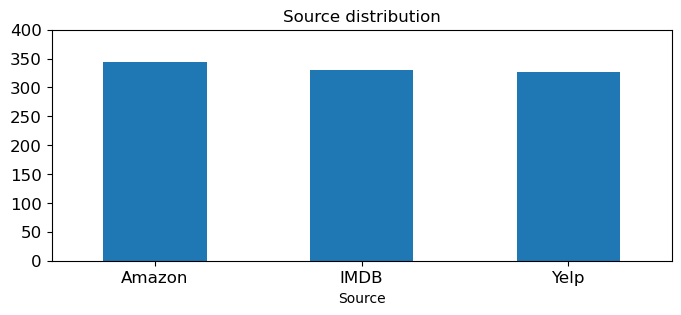

In [31]:
print(df_sample.Source.value_counts())
# plot barchart for df_sample
df_sample.Source.value_counts().plot(kind = 'bar',
                                           title = 'Source distribution',
                                           ylim = [0, 400], 
                                           rot = 0, fontsize = 12, figsize = (8,3))

### >>> **Exercise 7 (5 min):**
Notice that for the `ylim` parameters we hardcoded the maximum value for y. Is it possible to automate this instead of hard-coding it? How would you go about doing that? (Hint: look at code above for clues)

<Axes: title={'center': 'Source distribution'}, xlabel='Source'>

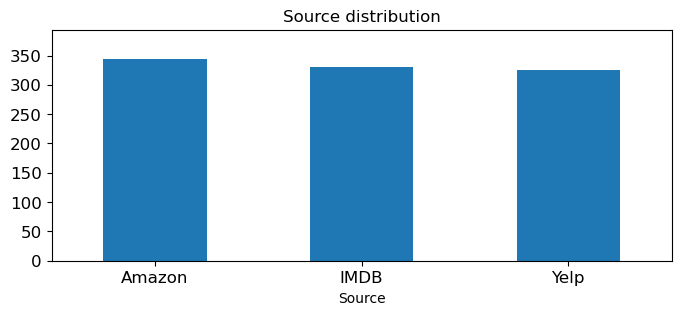

In [32]:
upper_bound = max(df_sample.Source.value_counts() + 50)
df_sample.Source.value_counts().plot(kind = 'bar',
                                           title = 'Source distribution',
                                           ylim = [0, upper_bound], 
                                           rot = 0, fontsize = 12, figsize = (8,3))

### >>> **Exercise 8 (take home):** 
We can also do a side-by-side comparison of the distribution between the two datasets, but maybe you can try that as an excerise. Below we show you an snapshot of the type of chart we are looking for. 

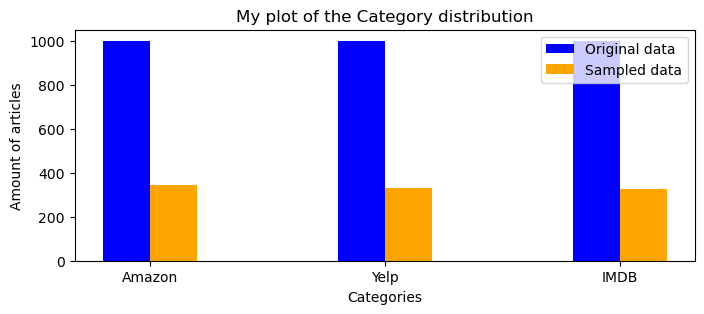

In [77]:
# Answer ex 8
df_sample
upper_bound_y = max(df.Source.value_counts() + 50) 
barwidth = 0.2
x = np.arange(len(sources))

plt.figure(figsize=(8,3)) #Set figure size
plt.ylim([0, upper_bound_y])
plt.bar(x - barwidth/2, df.Source.value_counts(), barwidth, color='b') #Condition blue bar
plt.bar(x + barwidth/2, df_sample.Source.value_counts(), barwidth, color='orange') #Conditions O bar
plt.title('My plot of the Category distribution')
plt.xlabel('Categories')
plt.ylabel('Amount of articles')
plt.xticks(x, sources) # name the X bars.
plt.legend(['Original data', 'Sampled data']) #Create legend
plt.show()


### 5.2 Feature Creation
Let's do some feature creation!

In [34]:
df['unigrams'] = df['sentence'].apply(lambda x: dmh.tokenize_text(x))
df[0:4]["unigrams"]

0    [So, there, is, no, way, for, me, to, plug, it...
1                 [Good, case, ,, Excellent, value, .]
2                        [Great, for, the, jawbone, .]
3    [Tied, to, charger, for, conversations, lastin...
Name: unigrams, dtype: object

In [35]:
df[0:4]

sentence Score  Source  \
0  So there is no way for me to plug it in here i...     0  Amazon   
1                        Good case, Excellent value.     1  Amazon   
2                             Great for the jawbone.     1  Amazon   
3  Tied to charger for conversations lasting more...     0  Amazon   

  Positive/Negative                                           unigrams  
0          Negative  [So, there, is, no, way, for, me, to, plug, it...  
1          Positive               [Good, case, ,, Excellent, value, .]  
2          Positive                      [Great, for, the, jawbone, .]  
3          Negative  [Tied, to, charger, for, conversations, lastin...

In [36]:
list(df[0:1]['unigrams'])

[['So',
  'there',
  'is',
  'no',
  'way',
  'for',
  'me',
  'to',
  'plug',
  'it',
  'in',
  'here',
  'in',
  'the',
  'US',
  'unless',
  'I',
  'go',
  'by',
  'a',
  'converter',
  '.']]

### 5.3 Feature subset selection
Time for Feature subset selection!

In [37]:
count_vect = CountVectorizer()
df_counts = count_vect.fit_transform(df.sentence) #learn the vocabulary and return document-term matrix
print(df_counts.shape)
print(df_counts[0])
print(count_vect.get_feature_names_out()[1234])
print(count_vect.get_feature_names_out()[2345])


(3000, 5155)
  (0, 4161)	1
  (0, 4545)	1
  (0, 2427)	1
  (0, 3043)	1
  (0, 4987)	1
  (0, 1829)	1
  (0, 2809)	1
  (0, 4609)	1
  (0, 3387)	1
  (0, 2432)	1
  (0, 2314)	2
  (0, 2158)	1
  (0, 4531)	1
  (0, 4835)	1
  (0, 4793)	1
  (0, 1982)	1
  (0, 647)	1
  (0, 1013)	1
designs
ineptly


In [38]:
analyze = count_vect.build_analyzer()
analyze(df.sentence[0])

['so',
 'there',
 'is',
 'no',
 'way',
 'for',
 'me',
 'to',
 'plug',
 'it',
 'in',
 'here',
 'in',
 'the',
 'us',
 'unless',
 'go',
 'by',
 'converter']

### **>>> Exercise 9 (5 min):**
Let's analyze the first record of our X dataframe with the new analyzer we have just built. Go ahead try it!

In [39]:
# Answer here
# How do we turn our array[0] text document into a tokenized text using the build_analyzer()
analyze(df.sentence[0])
analyze(" ".join(list(df[:1].sentence)))

['so',
 'there',
 'is',
 'no',
 'way',
 'for',
 'me',
 'to',
 'plug',
 'it',
 'in',
 'here',
 'in',
 'the',
 'us',
 'unless',
 'go',
 'by',
 'converter']

In [40]:
# We can check the shape of this matrix by:
print(df_counts.shape)
# We can obtain the feature names of the vectorizer, i.e., the terms
# usually on the horizontal axis
count_vect.get_feature_names_out()[0:10]
print(df_counts[0:5, 0:100].toarray())
print(count_vect.get_feature_names_out()[0:1])

(3000, 5155)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0

### **>>> Exercise 10 (take home):**
We said that the `1` at the beginning of the fifth record represents the `00` term. Notice that there is another 1 in the same record. Can you provide code that can verify what word this 1 represents from the vocabulary. Try to do this as efficient as possible.

HERE THERE IS NONE SO WILL DO IT FOR THE first != 0 element in the 4th record

In [41]:
# Answer here
indices = np.where(df_counts[3:4].toarray() == 1)[1] #Get the indexes of all elements == 1
count_vect.get_feature_names_out()[indices[0]] #Print the second 1. 

'45'

TIME FOR SOME HEATMAP ACTION

['term_00', 'term_10', 'term_100', 'term_11', 'term_12', 'term_13', 'term_15', 'term_15g', 'term_15pm', 'term_17', 'term_18', 'term_18th', 'term_1928', 'term_1947', 'term_1948', 'term_1949', 'term_1971', 'term_1973', 'term_1979', 'term_1980']
['doc_0', 'doc_1', 'doc_2', 'doc_3', 'doc_4', 'doc_5', 'doc_6', 'doc_7', 'doc_8', 'doc_9', 'doc_10', 'doc_11', 'doc_12', 'doc_13', 'doc_14', 'doc_15', 'doc_16', 'doc_17', 'doc_18', 'doc_19']
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0

term_00  term_10  term_100  term_11  term_12  term_13  term_15  \
doc_0         0        0         0        0        0        0        0   
doc_1         0        0         0        0        0        0        0   
doc_2         0        0         0        0        0        0        0   
doc_3         0        0         0        0        0        0        0   
doc_4         0        0         0        0        0        0        0   
doc_5         0        0         0        0        0        0        0   
doc_6         0        0         0        0        0        0        0   
doc_7         0        0         0        0        0        0        0   
doc_8         0        0         0        0        0        0        0   
doc_9         0        0         0        0        0        0        0   
doc_10        0        0         0        0        0        0        0   
doc_11        0        0         0        0        0        0        0   
doc_12        0        0         0        0        0        0        0   
doc_13        0        0         0        0        0        0        0   
doc_14        0        0         0        0        0        0        0   
doc_15        0        0         0        0        0        0        0   
doc_16        0        0         0        0        0        0        0   
doc_17        0        0         0        0        0        0        0   
doc_18        0        0         0        0        0        0        0   
doc_19        0        0         0        0        0        0        0   

        term_15g  term_15pm  term_17  term_18  term_18th  term_1928  \
doc_0          0          0        0        0          0          0   
doc_1          0          0        0        0          0          0   
doc_2          0          0        0        0          0          0   
doc_3          0          0        0        0          0          0   
doc_4          0          0        0        0          0          0   
doc_5          0          0        0        0          0          0   
doc_6          0          0        0        0          0          0   
doc_7          0          0        0        0          0          0   
doc_8          0          0        0        0          0          0   
doc_9          0          0        0        0          0          0   
doc_10         0          0        0        0          0          0   
doc_11         0          0        0        0          0          0   
doc_12         0          0        0        0          0          0   
doc_13         0          0        0        0          0          0   
doc_14         0          0        0        0          0          0   
doc_15         0          0        0        0          0          0   
doc_16         0          0        0        0          0          0   
doc_17         0          0        0        0          0          0   
doc_18         0          0        0        0          0          0   
doc_19         0          0        0        0          0          0   

        term_1947  term_1948  term_1949  term_1971  term_1973  term_1979  \
doc_0           0          0          0          0          0          0   
doc_1           0          0          0          0          0          0   
doc_2           0          0          0          0          0          0   
doc_3           0          0          0          0          0          0   
doc_4           0          0          0          0          0          0   
doc_5           0          0          0          0          0          0   
doc_6           0          0          0          0          0          0   
doc_7           0          0          0          0          0          0   
doc_8           0          0          0          0          0          0   
doc_9           0          0          0          0          0          0   
doc_10          0          0          0          0          0          0   
doc_11          0          0          0          

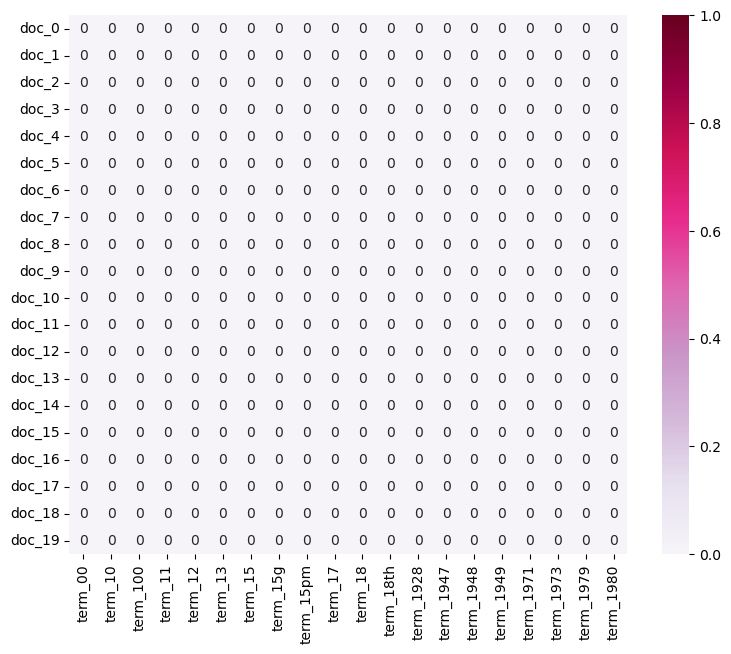

In [42]:
# first twenty features only
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[0:20]]
print(plot_x)
# obtain document index
plot_y = ["doc_"+ str(i) for i in list(df.index)[0:20]]
print(plot_y)
plot_z = df_counts[0:20, 0:20].toarray() #X_counts[how many documents, how many terms]
print(plot_z)

df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
display(df_todraw)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=1, annot=True)

Here we can see that the first 20 terms doesn't appear in the first 20 documents

### **>>> Exercise 11 (take home):** 
From the chart above, we can see how sparse the term-document matrix is; i.e., there is only one terms with frequency of `1` in the subselection of the matrix. By the way, you may have noticed that we only selected 20 articles and 20 terms to plot the histrogram. As an excersise you can try to modify the code above to plot the entire term-document matrix or just a sample of it. How would you do this efficiently? Remember there is a lot of words in the vocab. Report below what methods you would use to get a nice and useful visualization

00  10  100  11  12  13  15  15g  15pm  17  ...  yucky  yukon  yum  yummy  \
0   0   0    0   0   0   0   0    0     0   0  ...      0      0    0      0   
1   0   0    0   0   0   0   0    0     0   0  ...      0      0    0      0   
2   0   0    0   0   0   0   0    0     0   0  ...      0      0    0      0   
3   0   0    0   0   0   0   0    0     0   0  ...      0      0    0      0   
4   0   0    0   0   0   0   0    0     0   0  ...      0      0    0      0   

   yun  z500a  zero  zillion  zombie  zombiez  
0    0      0     0        0       0        0  
1    0      0     0        0       0        0  
2    0      0     0        0       0        0  
3    0      0     0        0       0        0  
4    0      0     0        0       0        0  

[5 rows x 5155 columns]

Index(['the', 'and', 'it', 'is', 'to', 'this', 'of', 'was', 'in', 'for',
       ...
       'honeslty', 'honor', 'hook', 'hooked', 'hoot', 'hoped', 'hopeless',
       'hopes', 'horrendous', 'zombiez'],
      dtype='object', length=5155)


the  and  it  is  to  this  of  was  in  for  ...  honeslty  honor  hook  \
0    1    0   1   1   1     0   0    0   2    1  ...         0      0     0   
1    0    0   0   0   0     0   0    0   0    0  ...         0      0     0   
2    1    0   0   0   0     0   0    0   0    1  ...         0      0     0   
3    0    0   0   0   1     0   0    0   0    1  ...         0      0     0   
4    1    0   0   1   0     0   0    0   0    0  ...         0      0     0   

   hooked  hoot  hoped  hopeless  hopes  horrendous  zombiez  
0       0     0      0         0      0           0        0  
1       0     0      0         0      0           0        0  
2       0     0      0         0      0           0        0  
3       0     0      0         0      0           0        0  
4       0     0      0         0      0           0        0  

[5 rows x 5155 columns]

<Axes: >

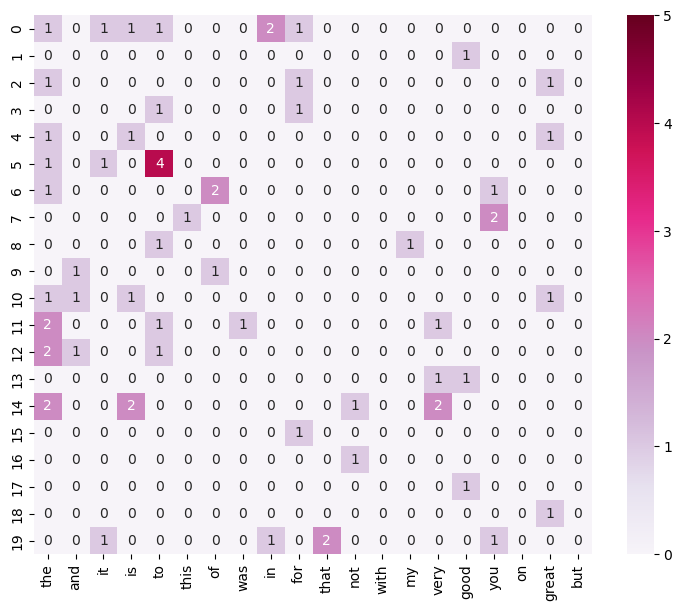

In [43]:
#make a dataframe of the dense matrix, each column is repr of each word.
df_heatmap = pd.DataFrame(df_counts.toarray(), columns=count_vect.get_feature_names_out()) 
display(df_heatmap[0:5])
#Create a new index by suming up the freq, then sorting them
index = df_heatmap.sum()
index = index.sort_values(ascending=False).index
print(index)
df_heatmap = df_heatmap[index]
display(df_heatmap[0:5])
#Finaly plot it
plt.subplots(figsize=(9, 7))
sns.heatmap(df_heatmap.iloc[:20,:20],              
    cmap="PuRd",
    vmin=0, vmax=5, annot=True)

### 5.4 Dimensionality Reduction

We are going to make use of Principal Component Analysis to efficiently reduce the dimensions of our data.

(3000, 5155)


(3000, 2)
['Amazon', 'Yelp', 'IMDB']


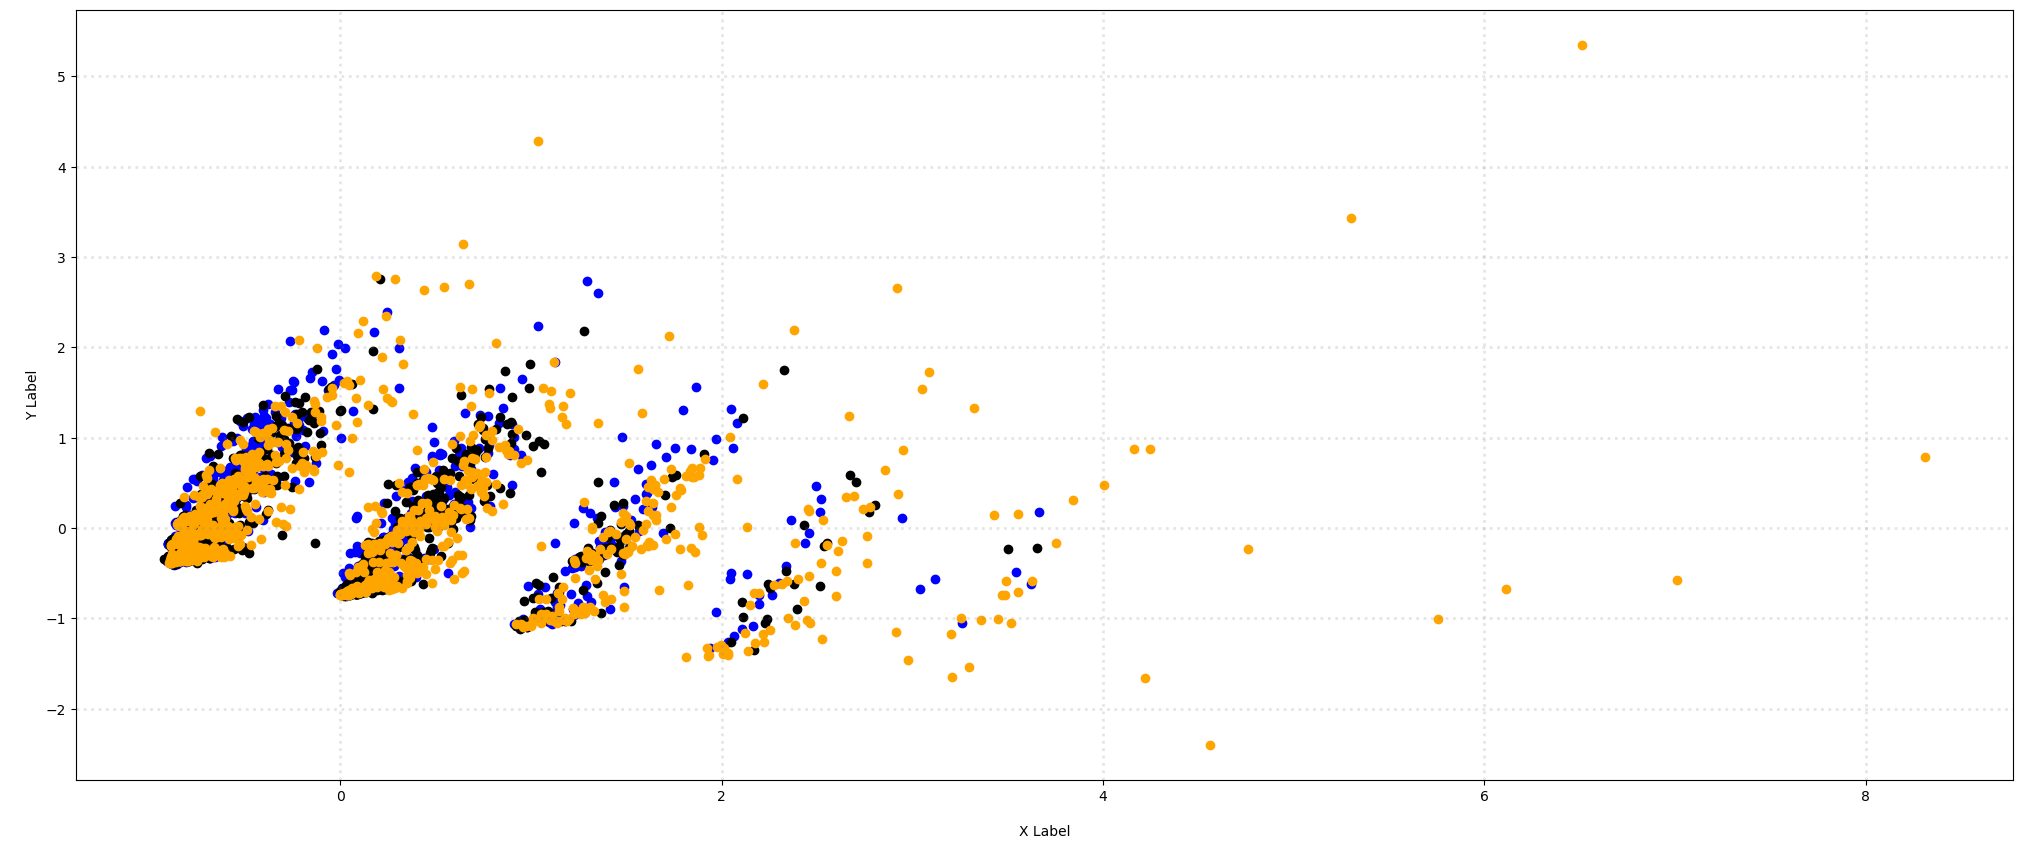

In [44]:
print(df_counts.shape)
df_reduced = PCA(n_components = 2).fit_transform(df_counts.toarray())
print(df_reduced.shape)
print(sources)
col = ['blue', 'black', 'orange']
# plot
fig = plt.figure(figsize = (25,10))
ax = fig.subplots()

for c, category in zip(col, sources):
    xs = df_reduced[df['Source'] == category].T[0]
    ys = df_reduced[df['Source'] == category].T[1]
   
    ax.scatter(xs, ys, c = c, marker='o')

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')

plt.show()

### >>> Exercise 12 (take home):
Please try to reduce the dimension to 3, and plot the result use 3-D plot. Use at least 3 different angle (camera position) to check your result and describe what you found.

$Hint$: you can refer to Axes3D in the documentation.

(3000, 3)


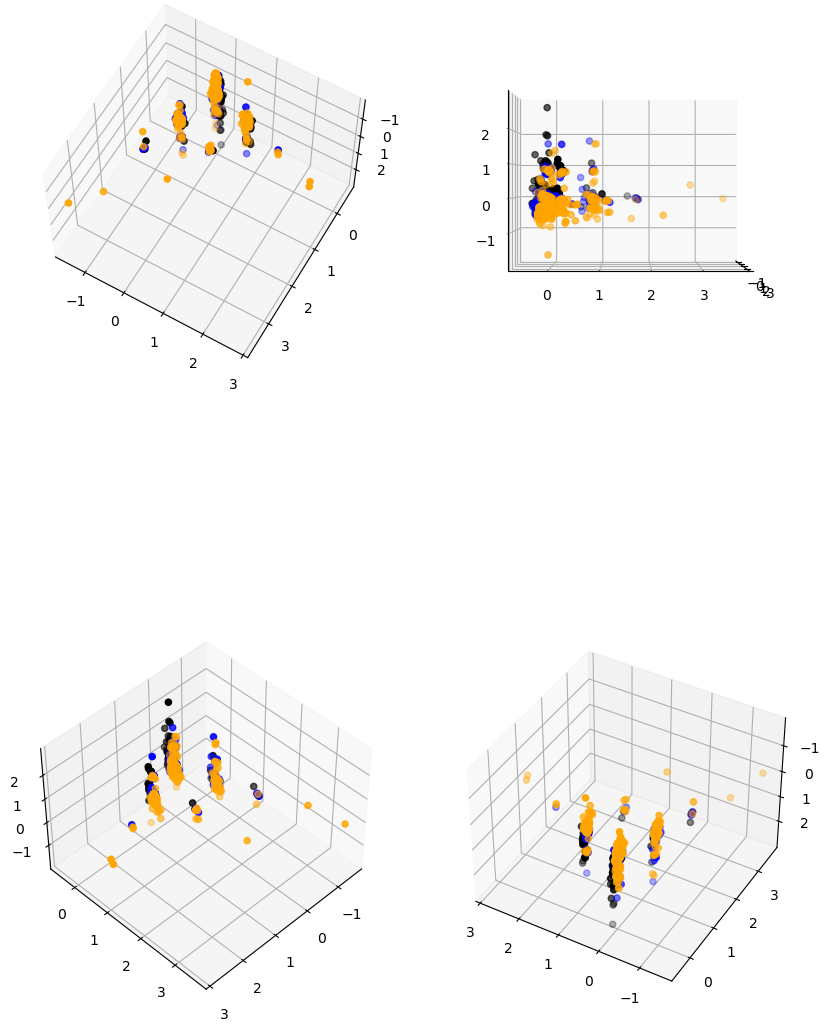

In [79]:
# Answer here

df_reduced = PCA(n_components = 3).fit_transform(df_counts.toarray())
print(df_reduced.shape)

fig = plt.figure(figsize = (10,30))


ax = fig.add_subplot(1,2,1, projection='3d')

for c, source in zip(col, sources):
    xs = df_reduced[df['Source'] == source].T[0]
    ys = df_reduced[df['Source'] == source].T[1]
    zs = df_reduced[df['Source'] == source].T[2]
    ax.scatter(xs, ys, zs,  c = c)


ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.view_init(45, 45)

ax = fig.add_subplot(1,2,2, projection='3d')
for c, source in zip(col, sources):
    xs = df_reduced[df['Source'] == source].T[0]
    ys = df_reduced[df['Source'] == source].T[1]
    zs = df_reduced[df['Source'] == source].T[2]
    ax.scatter(xs, ys, zs,  c = c)

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.view_init(-140, 60)

ax = fig.add_subplot(2,2,1, projection='3d')
for c, source in zip(col, sources):
    xs = df_reduced[df['Source'] == source].T[0]
    ys = df_reduced[df['Source'] == source].T[1]
    zs = df_reduced[df['Source'] == source].T[2]
    ax.scatter(xs, ys, zs,  c = c)


ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.view_init(240,240)

ax = fig.add_subplot(2,2,2, projection='3d')
for c, source in zip(col, sources):
    xs = df_reduced[df['Source'] == source].T[0]
    ys = df_reduced[df['Source'] == source].T[1]
    zs = df_reduced[df['Source'] == source].T[2]
    ax.scatter(xs, ys, zs,  c = c)


ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.view_init(0,0)


plt.show()

There is no real conclusions to be drawn from this result

### 5.5 Attribute Transformation / Aggregation
On the topic of attribute transformation, we will take the word distribution and put the distribution in a scale that makes it easy to analyze patterns in the distrubution of words. Let us get into it!

In [46]:
# note this takes time to compute. You may want to reduce the amount of terms you want to compute frequencies for
term_frequencies = []
print(df_counts.shape[1])
for j in range(0,df_counts.shape[1]):
    term_frequencies.append(sum(df_counts[:,j].toarray()))
term_frequencies = np.asarray(df_counts.sum(axis=0))[0]
print(term_frequencies[0]) #sum of first term

5155


1


c:\Users\albre\anaconda3\envs\DataMining\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\albre\anaconda3\envs\DataMining\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\albre\anaconda3\envs\DataMining\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



[Text(0, 0, '00'),
 Text(1, 0, '10'),
 Text(2, 0, '100'),
 Text(3, 0, '11'),
 Text(4, 0, '12'),
 Text(5, 0, '13'),
 Text(6, 0, '15'),
 Text(7, 0, '15g'),
 Text(8, 0, '15pm'),
 Text(9, 0, '17'),
 Text(10, 0, '18'),
 Text(11, 0, '18th'),
 Text(12, 0, '1928'),
 Text(13, 0, '1947'),
 Text(14, 0, '1948'),
 Text(15, 0, '1949'),
 Text(16, 0, '1971'),
 Text(17, 0, '1973'),
 Text(18, 0, '1979'),
 Text(19, 0, '1980'),
 Text(20, 0, '1986'),
 Text(21, 0, '1995'),
 Text(22, 0, '1998'),
 Text(23, 0, '20'),
 Text(24, 0, '2000'),
 Text(25, 0, '2005'),
 Text(26, 0, '2006'),
 Text(27, 0, '2007'),
 Text(28, 0, '20th'),
 Text(29, 0, '2160'),
 Text(30, 0, '23'),
 Text(31, 0, '24'),
 Text(32, 0, '25'),
 Text(33, 0, '2mp'),
 Text(34, 0, '30'),
 Text(35, 0, '30s'),
 Text(36, 0, '325'),
 Text(37, 0, '35'),
 Text(38, 0, '350'),
 Text(39, 0, '375'),
 Text(40, 0, '3o'),
 Text(41, 0, '40'),
 Text(42, 0, '40min'),
 Text(43, 0, '42'),
 Text(44, 0, '44'),
 Text(45, 0, '45'),
 Text(46, 0, '4s'),
 Text(47, 0, '4ths'),


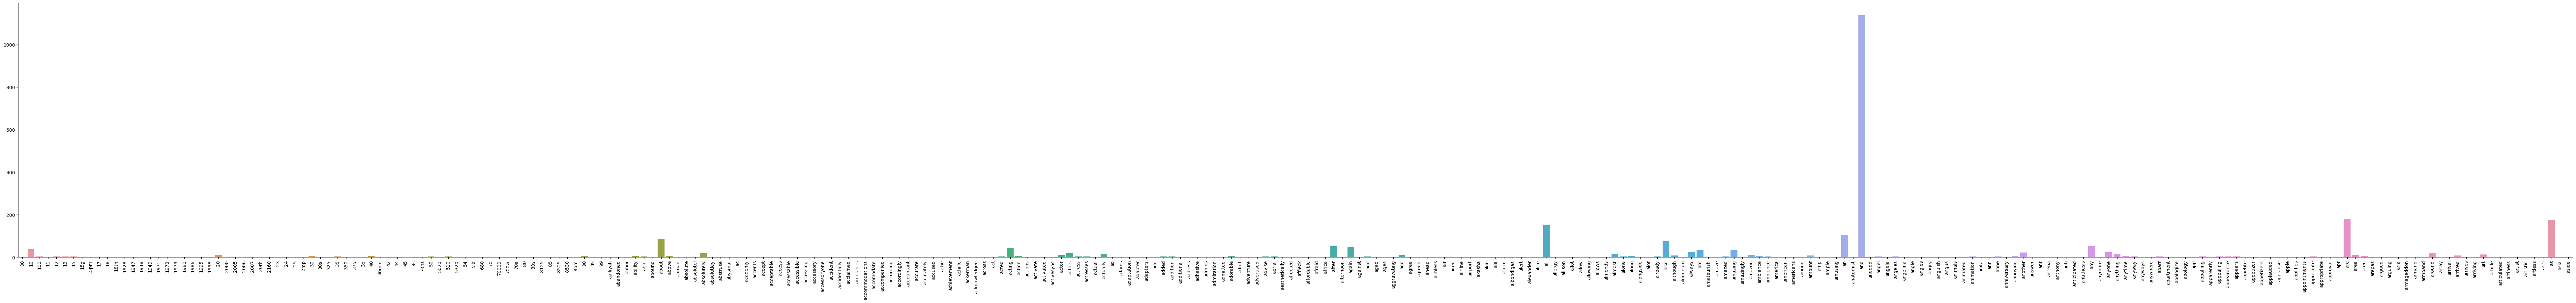

In [47]:
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300], 
            y=term_frequencies[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90)

### >>> **Exercise 13 (take home):**
If you want a nicer interactive visualization here, I would encourage you try to install and use plotly to achieve this.

In [48]:
column_sum = np.asarray((df_counts.sum(axis=0)))[0] #create an array with word freq
data = {'Words' : count_vect.get_feature_names_out(1),
        'Frequency' : column_sum}
df_freq = pd.DataFrame(data)
print("Size of df: " + str(df_freq.shape))
fig = px.bar(df_freq, x = 'Words', y = 'Frequency')
fig.show()
#The plot is hard to navigate in due to the large dimensionality

Size of df: (5155, 2)


### >>> **Exercise 14 (take home):** 
The chart above only contains 300 vocabulary in the documents, and it's already computationally intensive to both compute and visualize. Can you efficiently reduce the number of terms you want to visualize as an exercise. 


In [49]:
# Answer here
# Here I will reduce the amount of words by only showing words that occurs more than 30 times but less
# than 50. Then I will plot the words that have a freq > 50.
df_30_50_freq = df_freq[(df_freq['Frequency'] > 30) & (df_freq['Frequency'] < 50)]
fig = px.bar(df_30_50_freq, x = 'Words', y = 'Frequency')
fig.show()
print(df_30_50_freq.shape)
df_most_common = df_freq[(df_freq['Frequency'] > 50)]
fig = px.bar(df_most_common, x = 'Words', y = 'Frequency')
fig.show()
#Majority of the words here are words that helps to build mening like 'that' 'is' 'are' 'and'
# which make sense.

(54, 2)


### >>> **Exercise 15 (take home):** 
Additionally, you can attempt to sort the terms on the `x-axis` by frequency instead of in alphabetical order. This way the visualization is more meaninfgul and you will be able to observe the so called [long tail](https://en.wikipedia.org/wiki/Long_tail) (get familiar with this term since it will appear a lot in data mining and other statistics courses). see picture below

![alt txt](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Long_tail.svg/1000px-Long_tail.svg.png)

In [50]:
# Answer here
#To get a better visualization of all the elements i apply the suggested log funciton.
sorted_df = df_freq.sort_values(by='Frequency', ascending=False)
sorted_df['LogFreq'] = [math.log(i) for i in sorted_df['Frequency']]
print(sorted_df)
fig = px.bar(sorted_df, x = 'Words', y = 'LogFreq')
fig.show()

#Since it is still a huge df and hence hard to see, I also plot one with only the first 500words.
sorted_df = df_freq.sort_values(by='Frequency', ascending=False)[0:500]
print(sorted_df)
fig = px.bar(sorted_df, x = 'Words', y = 'Frequency')
fig.show()

           Words  Frequency   LogFreq
4531         the       1953  7.577122
216          and       1138  7.037028
2432          it        789  6.670766
2427          is        754  6.625392
4609          to        670  6.507278
...          ...        ...       ...
2216       hoped          1  0.000000
2218    hopeless          1  0.000000
2219       hopes          1  0.000000
2221  horrendous          1  0.000000
5154     zombiez          1  0.000000

[5155 rows x 3 columns]

         Words  Frequency
4531       the       1953
216        and       1138
2432        it        789
2427        is        754
4609        to        670
...        ...        ...
389        bar          9
785      check          9
4359     style          9
1462    eating          9
4945  waitress          9

[500 rows x 2 columns]


c:\Users\albre\anaconda3\envs\DataMining\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\albre\anaconda3\envs\DataMining\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

c:\Users\albre\anaconda3\envs\DataMining\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



[Text(0, 0, '00'),
 Text(1, 0, '10'),
 Text(2, 0, '100'),
 Text(3, 0, '11'),
 Text(4, 0, '12'),
 Text(5, 0, '13'),
 Text(6, 0, '15'),
 Text(7, 0, '15g'),
 Text(8, 0, '15pm'),
 Text(9, 0, '17'),
 Text(10, 0, '18'),
 Text(11, 0, '18th'),
 Text(12, 0, '1928'),
 Text(13, 0, '1947'),
 Text(14, 0, '1948'),
 Text(15, 0, '1949'),
 Text(16, 0, '1971'),
 Text(17, 0, '1973'),
 Text(18, 0, '1979'),
 Text(19, 0, '1980'),
 Text(20, 0, '1986'),
 Text(21, 0, '1995'),
 Text(22, 0, '1998'),
 Text(23, 0, '20'),
 Text(24, 0, '2000'),
 Text(25, 0, '2005'),
 Text(26, 0, '2006'),
 Text(27, 0, '2007'),
 Text(28, 0, '20th'),
 Text(29, 0, '2160'),
 Text(30, 0, '23'),
 Text(31, 0, '24'),
 Text(32, 0, '25'),
 Text(33, 0, '2mp'),
 Text(34, 0, '30'),
 Text(35, 0, '30s'),
 Text(36, 0, '325'),
 Text(37, 0, '35'),
 Text(38, 0, '350'),
 Text(39, 0, '375'),
 Text(40, 0, '3o'),
 Text(41, 0, '40'),
 Text(42, 0, '40min'),
 Text(43, 0, '42'),
 Text(44, 0, '44'),
 Text(45, 0, '45'),
 Text(46, 0, '4s'),
 Text(47, 0, '4ths'),


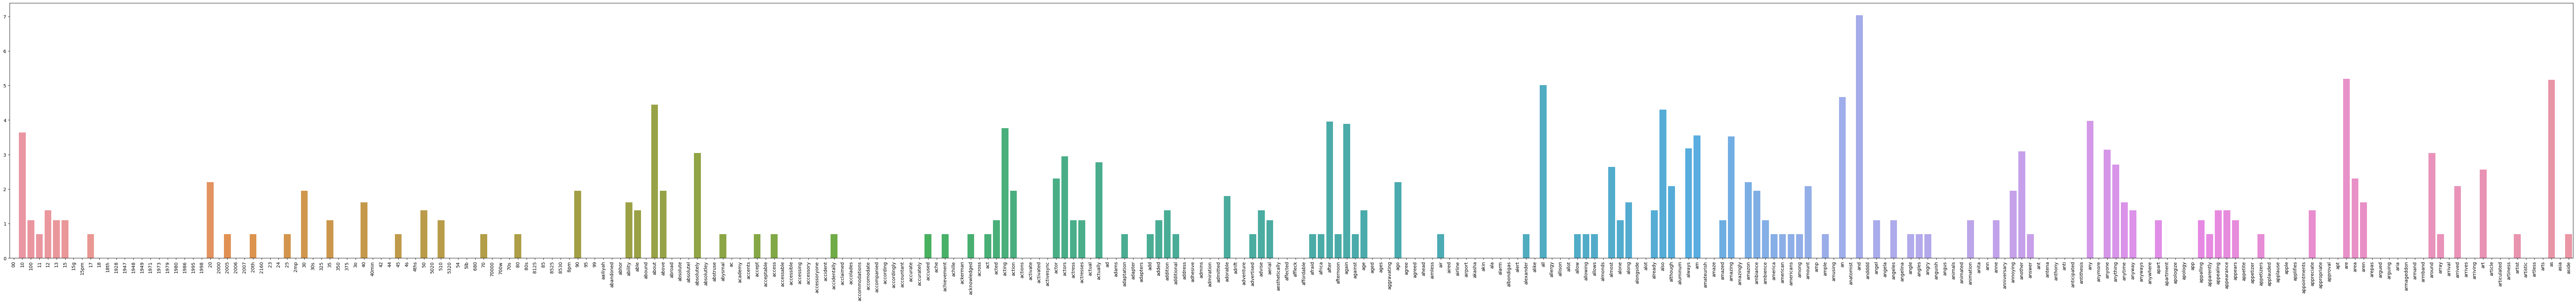

In [51]:
term_frequencies_log = [math.log(i) for i in term_frequencies]
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300],
                y=term_frequencies_log[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90)

### 5.6 Discretization and Binarization
Lets try some binarization

In [52]:
mlb = preprocessing.LabelBinarizer()
mlb.fit(df.Source)
df['bin_category'] = mlb.transform(df['Source']).tolist()
display(df[0:5])

sentence Score  Source  \
0  So there is no way for me to plug it in here i...     0  Amazon   
1                        Good case, Excellent value.     1  Amazon   
2                             Great for the jawbone.     1  Amazon   
3  Tied to charger for conversations lasting more...     0  Amazon   
4                                  The mic is great.     1  Amazon   

  Positive/Negative                                           unigrams  \
0          Negative  [So, there, is, no, way, for, me, to, plug, it...   
1          Positive               [Good, case, ,, Excellent, value, .]   
2          Positive                      [Great, for, the, jawbone, .]   
3          Negative  [Tied, to, charger, for, conversations, lastin...   
4          Positive                           [The, mic, is, great, .]   

  bin_category  
0    [1, 0, 0]  
1    [1, 0, 0]  
2    [1, 0, 0]  
3    [1, 0, 0]  
4    [1, 0, 0]

### >>> **Exercise 16 (take home):**
Try to generate the binarization using the `category_name` column instead. Does it work?

In [53]:
mlb = preprocessing.LabelBinarizer()
mlb.fit(df['Positive/Negative'])
df['bin_category'] = mlb.transform(df['Positive/Negative']).tolist()
df[0:9]

sentence Score  Source  \
0  So there is no way for me to plug it in here i...     0  Amazon   
1                        Good case, Excellent value.     1  Amazon   
2                             Great for the jawbone.     1  Amazon   
3  Tied to charger for conversations lasting more...     0  Amazon   
4                                  The mic is great.     1  Amazon   
5  I have to jiggle the plug to get it to line up...     0  Amazon   
6  If you have several dozen or several hundred c...     0  Amazon   
7        If you are Razr owner...you must have this!     1  Amazon   
8                Needless to say, I wasted my money.     0  Amazon   

  Positive/Negative                                           unigrams  \
0          Negative  [So, there, is, no, way, for, me, to, plug, it...   
1          Positive               [Good, case, ,, Excellent, value, .]   
2          Positive                      [Great, for, the, jawbone, .]   
3          Negative  [Tied, to, charger, for, conversations, lastin...   
4          Positive                           [The, mic, is, great, .]   
5          Negative  [I, have, to, jiggle, the, plug, to, get, it, ...   
6          Negative  [If, you, have, several, dozen, or, several, h...   
7          Positive  [If, you, are, Razr, owner, ..., you, must, ha...   
8          Negative    [Needless, to, say, ,, I, wasted, my, money, .]   

  bin_category  
0          [0]  
1          [1]  
2          [1]  
3          [0]  
4          [1]  
5          [0]  
6          [0]  
7          [1]  
8          [0]

# 6. Data Exploration

Sometimes you need to take a peek at your data to understand the relationships in your dataset. Here, we will focus in a similarity example. Let's take 3 documents and compare them.

In [54]:
# We retrieve 3 sentences for a random record
document_to_transform_1 = []
random_record_1 = df.iloc[50]
random_record_1 = random_record_1['sentence']
document_to_transform_1.append(random_record_1)

document_to_transform_2 = []
random_record_2 = df.iloc[100]
random_record_2 = random_record_2['sentence']
document_to_transform_2.append(random_record_2)

document_to_transform_3 = []
random_record_3 = df.iloc[150]
random_record_3 = random_record_3['sentence']
document_to_transform_3.append(random_record_3)
print(document_to_transform_1)
print(document_to_transform_2)
print(document_to_transform_3)

["Not loud enough and doesn't turn on like it should."]
['Integrated seamlessly with the Motorola RAZR phone.']
['I Was Hoping for More.']


In [55]:


# Transform sentence with Vectorizers
document_vector_count_1 = count_vect.transform(document_to_transform_1)
document_vector_count_2 = count_vect.transform(document_to_transform_2)
document_vector_count_3 = count_vect.transform(document_to_transform_3)

# Binarize vectors to simplify: 0 for abscence, 1 for prescence
document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)

# print vectors
print("Let's take a look at the count vectors:")
print(document_vector_count_1.todense())
print(document_vector_count_2.todense())
print(document_vector_count_3.todense())

Let's take a look at the count vectors:
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]


In [56]:


# Calculate Cosine Similarity
cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)

cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)

# Print 
print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":cos_sim_count_2_3})


print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":cos_sim_count_3_3})


Cosine Similarity using count bw 1 and 2: 0.000000
Cosine Similarity using count bw 1 and 3: 0.000000
Cosine Similarity using count bw 2 and 3: 0.000000
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000
Cosine Similarity using count bw 3 and 3: 1.000000


C:\Users\albre\AppData\Local\Temp\ipykernel_25656\2060404237.py:11: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\albre\AppData\Local\Temp\ipykernel_25656\2060404237.py:12: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\albre\AppData\Local\Temp\ipykernel_25656\2060404237.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\albre\AppData\Local\Temp\ipykernel_25656\2060404237.py:16: DeprecationWarning:

Conversion of an array with ndim > 0 t

The sentences are 100% different and we therefore get a score of 0...

### Section 3 of the lab.
Third: please attempt the following tasks on **the new dataset**. __This part is worth 30% of your grade.__
1.  Generate meaningful **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
2. Generate **TF-IDF features** from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency). Refer to this Sciki-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) .
3. Implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers. Comment on the differences.  Refer to this [article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/).

### Section 3:1. New meaningful data visualizations
Here I will create a new data visualizations for the dataset used in section 2.



In [57]:
#First clean up the df
print(df.shape)
display(df[0:5])
df = df.drop(['unigrams','bin_category'], axis = 1)
display(df[0:5])


(3000, 6)


sentence Score  Source  \
0  So there is no way for me to plug it in here i...     0  Amazon   
1                        Good case, Excellent value.     1  Amazon   
2                             Great for the jawbone.     1  Amazon   
3  Tied to charger for conversations lasting more...     0  Amazon   
4                                  The mic is great.     1  Amazon   

  Positive/Negative                                           unigrams  \
0          Negative  [So, there, is, no, way, for, me, to, plug, it...   
1          Positive               [Good, case, ,, Excellent, value, .]   
2          Positive                      [Great, for, the, jawbone, .]   
3          Negative  [Tied, to, charger, for, conversations, lastin...   
4          Positive                           [The, mic, is, great, .]   

  bin_category  
0          [0]  
1          [1]  
2          [1]  
3          [0]  
4          [1]

sentence Score  Source  \
0  So there is no way for me to plug it in here i...     0  Amazon   
1                        Good case, Excellent value.     1  Amazon   
2                             Great for the jawbone.     1  Amazon   
3  Tied to charger for conversations lasting more...     0  Amazon   
4                                  The mic is great.     1  Amazon   

  Positive/Negative  
0          Negative  
1          Positive  
2          Positive  
3          Negative  
4          Positive

Lets create some visulazations for the data using wordclud, one for each data source (Aazon, Yelp, IMDB)

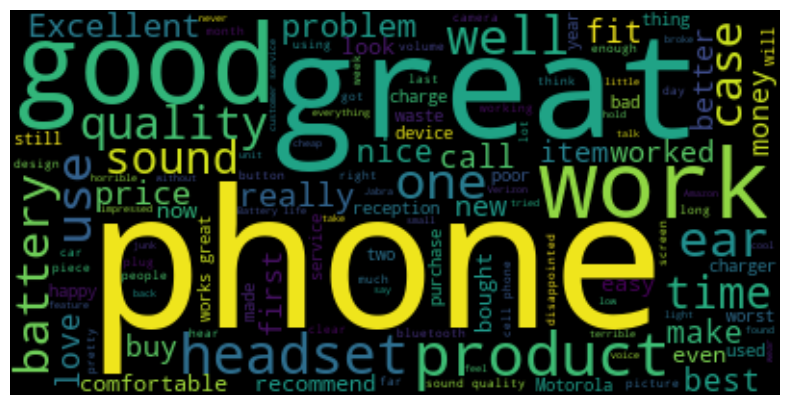

In [58]:

#First Amazon
text_data = " ".join(df[df['Source'] == 'Amazon']['sentence'])
my_wordcloud = WordCloud().generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(my_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

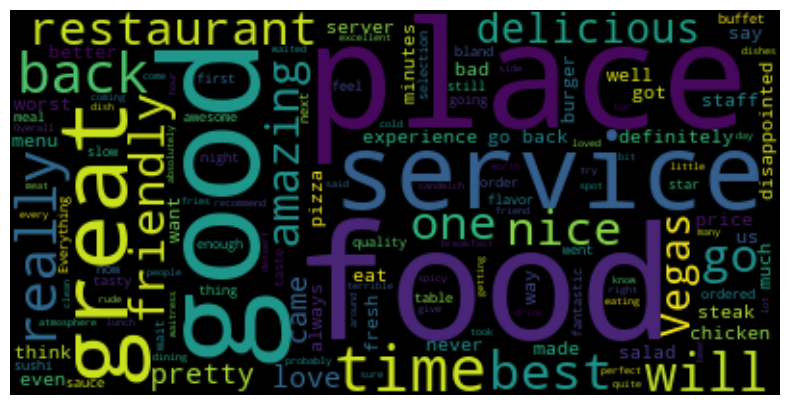

In [59]:
#Then Yelp
text_data = " ".join(df[df['Source'] == 'Yelp']['sentence'])
my_wordcloud = WordCloud().generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(my_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

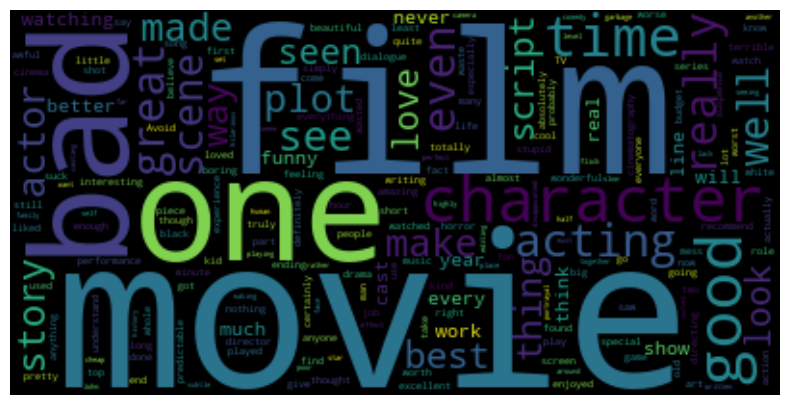

In [60]:
#Lastly IMDB
text_data = " ".join(df[df['Source'] == 'IMDB']['sentence'])
my_wordcloud = WordCloud().generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(my_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Above you could find three rather interesting visualizations if you ask me.

One other thing one could do is remomve all the stopwords in the df so this is what I will do and then print a bar plot of it to compare with the old barplot. The worldcloud library also removes the stopword automaticly for its plot.

In [61]:
stop_words = set(stopwords.words('english'))
display(stop_words)

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [62]:
#Remove stopwords
#The defined clean function below is far from optimal, but does the work for this purpose.
def clean(sentence, not_useful_words):
    sentence = list(sentence.split(' '))
    clean_sentence = ''
    for word in sentence:
        add = True
        for no_use in not_useful_words:
            if word == no_use:
                add = False
        if add:
            clean_sentence += " "
            clean_sentence = clean_sentence + word
    return clean_sentence

df['clean_sentence'] = df.sentence.apply(lambda x: clean(x, stop_words))
display(df)

sentence Score  Source  \
0     So there is no way for me to plug it in here i...     0  Amazon   
1                           Good case, Excellent value.     1  Amazon   
2                                Great for the jawbone.     1  Amazon   
3     Tied to charger for conversations lasting more...     0  Amazon   
4                                     The mic is great.     1  Amazon   
...                                                 ...   ...     ...   
2995  I just got bored watching Jessice Lange take h...     0    IMDB   
2996  Unfortunately, any virtue in this film's produ...     0    IMDB   
2997                   In a word, it is embarrassing.       0    IMDB   
2998                               Exceptionally bad!       0    IMDB   
2999  All in all its an insult to one's intelligence...     0    IMDB   

     Positive/Negative                                     clean_sentence  
0             Negative              So way plug US unless I go converter.  
1             Positive                        Good case, Excellent value.  
2             Positive                                     Great jawbone.  
3             Negative   Tied charger conversations lasting 45 minutes...  
4             Positive                                     The mic great.  
...                ...                                                ...  
2995          Negative   I got bored watching Jessice Lange take cloth...  
2996          Negative   Unfortunately, virtue film's production work ...  
2997          Negative                           In word, embarrassing.    
2998          Negative                               Exceptionally bad!    
2999          Negative   All insult one's intelligence huge waste mone...  

[3000 rows x 5 columns]

In [63]:
#Plot it in an interactive bar plot.

df_counts = count_vect.fit_transform(df.clean_sentence) #learn the vocabulary and return document-term matrix

column_sum = np.asarray((df_counts.sum(axis=0)))[0] #create an array with word freq
data = {'Words' : count_vect.get_feature_names_out(1),
        'Frequency' : column_sum}
df_freq = pd.DataFrame(data)
print("Size of new df: " + str(df_freq.shape))
print("Size of old df: (5155, 2)")
fig = px.bar(df_freq, x = 'Words', y = 'Frequency')
fig.show()

Size of new df: (5137, 2)
Size of old df: (5155, 2)


Since there is still a lot of words, further limitations is done below for more meaningful representations

In [64]:
#To get a better visualization of all the elements i apply the log funciton.
sorted_df = df_freq.sort_values(by='Frequency', ascending=False)
sorted_df['LogFreq'] = [math.log(i) for i in sorted_df['Frequency']]
print(sorted_df)
fig = px.bar(sorted_df, x = 'Words', y = 'LogFreq')
fig.show()

#Since it is still a huge df and hence hard to see, I also plot one with only the first 500words.
sorted_df = df_freq.sort_values(by='Frequency', ascending=False)[0:500]
print(sorted_df)
fig = px.bar(sorted_df, x = 'Words', y = 'Frequency')
fig.show()

          Words  Frequency   LogFreq
4518        the        479  6.171701
2423         it        337  5.820083
1989       good        230  5.438079
2019      great        210  5.347108
4545       this        201  5.303305
...         ...        ...       ...
2191       hole          1  0.000000
2193    holiday          1  0.000000
2194  hollander          1  0.000000
2200   homework          1  0.000000
5136    zombiez          1  0.000000

[5137 rows x 3 columns]


        Words  Frequency
4518      the        479
2423       it        337
1989     good        230
2019    great        210
4545     this        201
...       ...        ...
4468   tasted          8
826    cinema          8
2241    human          8
1746  finally          8
3290  perhaps          8

[500 rows x 2 columns]


This visualization may not be the most useful one. However in the scope of this lab assignment  still believe it is ok, one could easily see, using the interactive plotly plot, the most common words. 

To create truly meaningful visualizations i believe that more advance models could be used. However, I personally believe that most such models are out of scope for this lab. 

### Section 3:2. Generate **TF-IDF features** from the tokens of each text.

 Generate **TF-IDF features** from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency). Refer to this Sciki-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) .

In [65]:
vectorizer = TfidfVectorizer()
df_tfidf = vectorizer.fit_transform(df.sentence)
print(df_tfidf.shape)
print(df_tfidf)


(3000, 5155)
  (0, 1013)	0.3982952688733835
  (0, 647)	0.22339534467811012
  (0, 1982)	0.23151202391135026
  (0, 4793)	0.33187908783248754
  (0, 4835)	0.27541073174789316
  (0, 4531)	0.08671624087955355
  (0, 2158)	0.22277715355242936
  (0, 2314)	0.2956111707754561
  (0, 2432)	0.11981679118086065
  (0, 3387)	0.30861882226834114
  (0, 4609)	0.1274893309301928
  (0, 2809)	0.22865092628677175
  (0, 1829)	0.15620766310867332
  (0, 4987)	0.24912940464591313
  (0, 3043)	0.22339534467811012
  (0, 2427)	0.12068394874592439
  (0, 4545)	0.20763211346881053
  (0, 4161)	0.18746612963796125
  (1, 4861)	0.6340416987777308
  (1, 1603)	0.47072204948062
  (1, 713)	0.513063291919973
  (1, 1993)	0.3364192842689825
  (2, 2449)	0.8233779731740677
  (2, 2023)	0.3996123298170515
  (2, 4531)	0.1955703921972776
  :	:
  (2996, 3122)	0.1800014535837048
  (2996, 243)	0.24739908124803336
  (2996, 4968)	0.1368596614485362
  (2996, 4558)	0.1274661319918594
  (2996, 2314)	0.15154775237713103
  (2997, 5089)	0.61347510

In [66]:
print(vectorizer.get_feature_names_out())
tfidf_analyze = vectorizer.build_analyzer()
tfidf_analyze(df.sentence[0])

['00' '10' '100' ... 'zillion' 'zombie' 'zombiez']


['so',
 'there',
 'is',
 'no',
 'way',
 'for',
 'me',
 'to',
 'plug',
 'it',
 'in',
 'here',
 'in',
 'the',
 'us',
 'unless',
 'go',
 'by',
 'converter']

We could use this to do the same operations as done with the count_vectorizer. Here i will only make the 3D plots to show how the plots have changed using tdif.

(3000, 3)


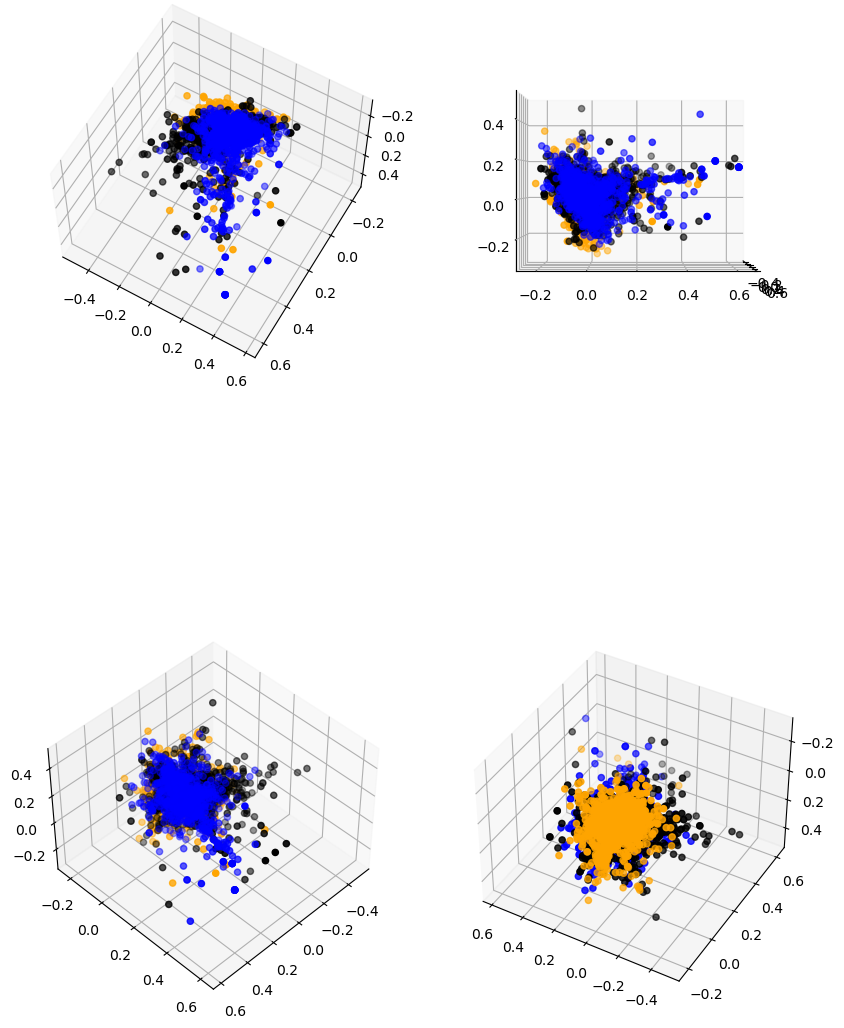

In [80]:

df_reduced = PCA(n_components = 3).fit_transform(df_tfidf.toarray())
print(df_reduced.shape)

fig = plt.figure(figsize = (10,30))


ax = fig.add_subplot(1,2,1, projection='3d')

for c, source in zip(col, sources):
    xs = df_reduced[df['Source'] == source].T[0]
    ys = df_reduced[df['Source'] == source].T[1]
    zs = df_reduced[df['Source'] == source].T[2]
    ax.scatter(xs, ys, zs,  c = c)


ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.view_init(45, 45)

ax = fig.add_subplot(1,2,2, projection='3d')
for c, source in zip(col, sources):
    xs = df_reduced[df['Source'] == source].T[0]
    ys = df_reduced[df['Source'] == source].T[1]
    zs = df_reduced[df['Source'] == source].T[2]
    ax.scatter(xs, ys, zs,  c = c)

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.view_init(-140, 60)

ax = fig.add_subplot(2,2,1, projection='3d')
for c, source in zip(col, sources):
    xs = df_reduced[df['Source'] == source].T[0]
    ys = df_reduced[df['Source'] == source].T[1]
    zs = df_reduced[df['Source'] == source].T[2]
    ax.scatter(xs, ys, zs,  c = c)


ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.view_init(240,240)

ax = fig.add_subplot(2,2,2, projection='3d')
for c, source in zip(col, sources):
    xs = df_reduced[df['Source'] == source].T[0]
    ys = df_reduced[df['Source'] == source].T[1]
    zs = df_reduced[df['Source'] == source].T[2]
    ax.scatter(xs, ys, zs,  c = c)


ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.view_init(0,0)
plt.show()

Here we could see that the distribution of the data points is very different from the countVect graphs.

### Section 3:3. Implement a simple **Naive Bayes classifier**
Implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers. Comment on the differences.  Refer to this [article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/).

In [68]:
#Split the data
df.Score = [int(i) for i in df.Score]
x_train, x_test, y_train, y_test = train_test_split(df.sentence, df.Score, test_size=0.2, random_state=42)
print(x_test.shape)
print(x_train.shape)

(600,)
(2400,)


In [69]:
#Create the two different vectorizers and then fit it on the train & test data
t_vectorizer = TfidfVectorizer()
c_vectorizer = CountVectorizer()
x_train_tf = t_vectorizer.fit_transform(x_train)
x_train_c = c_vectorizer.fit_transform(x_train)
x_test_tf = t_vectorizer.transform(x_test)
x_test_c = c_vectorizer.transform(x_test)
print(x_train_tf)

  (0, 1617)	0.17696220438399413
  (0, 2876)	0.35729077261564507
  (0, 4416)	0.25909850823709424
  (0, 1729)	0.27120329050785486
  (0, 4527)	0.4122779583999793
  (0, 3651)	0.2103882165275538
  (0, 3504)	0.23548397651493966
  (0, 975)	0.3373429481198681
  (0, 3970)	0.29974206002404713
  (0, 1868)	0.20576869370225345
  (0, 3999)	0.2387726570213362
  (0, 2717)	0.35729077261564507
  (1, 2962)	0.25527265480000655
  (1, 2480)	0.2953828440939173
  (1, 4450)	0.2953828440939173
  (1, 572)	0.17000842563392382
  (1, 3323)	0.28057936664691824
  (1, 3033)	0.2953828440939173
  (1, 2603)	0.2953828440939173
  (1, 642)	0.2953828440939173
  (1, 1410)	0.28057936664691824
  (1, 210)	0.2331427168138798
  (1, 74)	0.2953828440939173
  (1, 4050)	0.0969187437506155
  (1, 3469)	0.25527265480000655
  :	:
  (2396, 4396)	0.3915720071790251
  (2396, 132)	0.44801423695805354
  (2396, 1754)	0.42839182776444107
  (2397, 2807)	0.48580733267409776
  (2397, 2482)	0.46046627770192106
  (2397, 4069)	0.3490191943516692
  (23

In [70]:
#Create the naive bayes model and fit them to the train data
mnb_tf = MultinomialNB()
mnb_tf.fit(x_train_tf, y_train)
mnb_c = MultinomialNB()
mnb_c.fit(x_train_c, y_train)


MultinomialNB()

In [71]:
#Use the models to predict on the test data
y_pred_tf = mnb_tf.predict(x_test_tf)
y_pred_c = mnb_c.predict(x_test_c)


In [72]:
#Create two confusion matrices for visualization and comparision. Print accuracy as well.
cm_tf = confusion_matrix(y_pred=y_pred_tf, y_true=y_test)
cm_c = confusion_matrix(y_pred=y_pred_c, y_true=y_test)

print(cm_tf)
print(cm_c)

# Calculate accuracy
accuracy_tf = (cm_tf[0, 0] + cm_tf[1, 1]) / cm_tf.sum()
accuracy_c = (cm_c[0, 0] + cm_c[1, 1]) / cm_c.sum()


# Display the accuracy
print("Accuracy tf:", accuracy_tf)
print("Accuracy c:", accuracy_c)

[[267  50]
 [ 48 235]]
[[266  51]
 [ 44 239]]
Accuracy tf: 0.8366666666666667
Accuracy c: 0.8416666666666667


TF-IDF features stands for term frequency (TF) - inverse document frequency (IDF). TF measures how often a word appears in a document, while IDF measures how unique or important a word is across the entire corpus.

The CountVectorization on the other hand represent text data by counting the number of times each word or term appears in a document. 

It is different ways of labelling data. 

When in this cased used to train a naive bayes model the countvectorization slightly outperforms the TD-IDF vectorizer. However, it is just a slight difference, the difference might vanish or become greater with a larger data-set for example. 

### Section 4 of the lab.
Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be habdled differently as well. What are those inefficent parts you noticed? How can you improve the Data preprocessing for these specific datasets?

#### 1 Remark
The way term frequencies is computed in section 5.5 is not the best since it creates a big dense array and loops through it. I believe that instead you could do as I show below using the built in sum function.

Below I have first imported the data and then I ran the two different models, at least for me there is a huge difference running the different cells.  

In [73]:
#Import for comparision
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', categories=categories,
                                  shuffle=True, random_state=42)
X = pd.DataFrame.from_records(dmh.format_rows(twenty_train), columns= ['text'])

In [74]:
count_vect1 = CountVectorizer()
master_counts = count_vect1.fit_transform(X.text) #learn the vocabulary and return document-term matrix
#The example from lab1-master

term_frequencies = []
print(master_counts.shape[1])
for j in range(0,master_counts.shape[1]):
    term_frequencies.append(sum(master_counts[:,j].toarray()))

35788


In [75]:
#My proposed solution
count_vect2 = CountVectorizer()
my_counts = count_vect2.fit_transform(X.text) #learn the vocabulary and return document-term matrix
column_sum = np.asarray((my_counts.sum(axis=0)))[0] #create an array with word freq


In [76]:
print(term_frequencies[0])
print(column_sum[0])

[134]
134


#### 2 Remark
I believe that as done in 5.3, trying to display a sparse matrix which such huge dimensions as dense matrix / document-term. Here we only displayed the first 5 rows and 100 columns and it still made no sense to me and hence isn't so meaningful.

#### 3 Remark
When doing the 3D plots in the PCA analyzis we by code changes the camera angles. This could be good if you want to create some plot for a presentation, however, if you just want to explore the data, an interactive 3D plot would be more preferable. 